#  create blackbox likelihood
- https://docs.pymc.io/notebooks/blackbox_external_likelihood.html

In [50]:
%matplotlib inline
%load_ext Cython

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

# for reproducibility here's some version info for modules used in this notebook
import theano
import theano.tensor as tt
import platform
import cython
import IPython
import matplotlib
import emcee
import corner
import os
print("Python version:     {}".format(platform.python_version()))
print("IPython version:    {}".format(IPython.__version__))
print("Cython version:     {}".format(cython.__version__))
print("GSL version:        {}".format(os.popen('gsl-config --version').read().strip()))
print("Numpy version:      {}".format(np.__version__))
print("Theano version:     {}".format(theano.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("emcee version:      {}".format(emcee.__version__))
print("corner version:     {}".format(corner.__version__))

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
Running on PyMC3 v3.8
Python version:     3.7.2
IPython version:    6.5.0
Cython version:     0.29.14
GSL version:        2.5
Numpy version:      1.15.1
Theano version:     1.0.4
Matplotlib version: 3.1.2
emcee version:      3.0.2
corner version:     2.0.1


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})


In [2]:
%load_ext Cython 

In [4]:
%%cython -a -I/usr/include -L/usr/lib/x86_64-linux-gnu -lgsl -lgslcblas -lm

import cython
cimport cython

import numpy as np
cimport numpy as np

### STUFF FOR USING GSL (FEEL FREE TO IGNORE!) ###

# declare GSL vector structure and functions
cdef extern from "gsl/gsl_block.h":
    cdef struct gsl_block:
        size_t size
        double * data

cdef extern from "gsl/gsl_vector.h":
    cdef struct gsl_vector:
        size_t size
        size_t stride
        double * data
        gsl_block * block
        int owner

    ctypedef struct gsl_vector_view:
        gsl_vector vector

    int gsl_vector_scale (gsl_vector * a, const double x) nogil
    int gsl_vector_add_constant (gsl_vector * a, const double x) nogil
    gsl_vector_view gsl_vector_view_array (double * base, size_t n) nogil

###################################################


# define your super-complicated model that uses loads of external codes
cpdef my_model(theta, np.ndarray[np.float64_t, ndim=1] x):
    """
    A straight line!

    Note:
        This function could simply be:

            m, c = thetha
            return m*x + x

        but I've made it more complicated for demonstration purposes
    """
    m, c = theta  # unpack line gradient and y-intercept

    cdef size_t length = len(x)  # length of x

    cdef np.ndarray line = np.copy(x)  # make copy of x vector
    cdef gsl_vector_view lineview      # create a view of the vector
    lineview = gsl_vector_view_array(<double *>line.data, length)

    # multiply x by m
    gsl_vector_scale(&lineview.vector, <double>m)

    # add c
    gsl_vector_add_constant(&lineview.vector, <double>c)

    # return the numpy array
    return line


# define your really-complicated likelihood function that uses loads of external codes
cpdef my_loglike(theta, np.ndarray[np.float64_t, ndim=1] x,
                 np.ndarray[np.float64_t, ndim=1] data, sigma):
    """
    A Gaussian log-likelihood function for a model with parameters given in theta
    """

    model = my_model(theta, x)

    return -(0.5/sigma**2)*np.sum((data - model)**2)

# wrapper 

In [11]:
import theano
import theano.tensor as tt

In [12]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [13]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma*np.random.randn(N) + truemodel

ndraws = 3000  # number of draws from the distribution
nburn = 1000   # number of "burn-in points" (which we'll discard)

# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:07<00:00, 1065.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


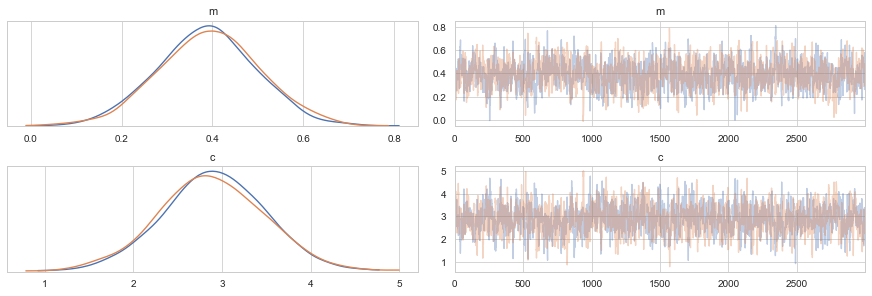

In [26]:
# plot the traces
_ = pm.traceplot(trace, var_names=['m','c'])#,lines={'m': mtrue, 'c': ctrue})


In [27]:
# put the chains in an array (for later!)
samples_pymc3 = np.vstack((trace['m'], trace['c'])).T

# to use NUTS

In [30]:
%%cython -a

import cython
cimport cython

import numpy as np
cimport numpy as np

import warnings

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In file included from /Users/Toshiaki/.ipython/cython/_cython_magic_29969045c849f3a1716915076b1eb24a.c:619:
In file included from /Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/Users/Toshiaki/.ipython/cython/_cython_magic_29969045c849f3a1716915076b1eb24a.c:7740:26: warning: code will never be executed [-Wunreachable-c

In [31]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)
        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.x, self.data, self.sigma)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

In [32]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model() as opmodel:
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:24<00:00, 320.65draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


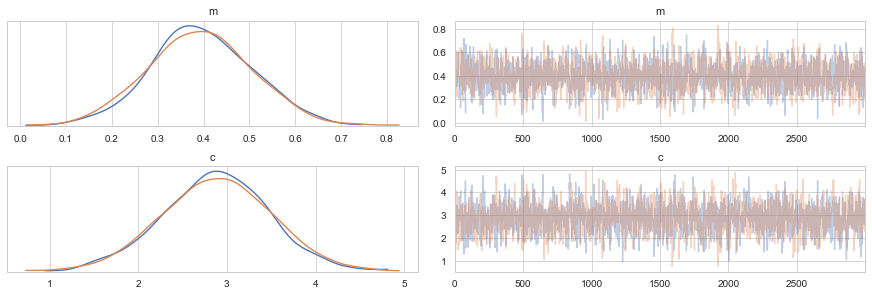

In [41]:
# plot the traces
_ = pm.traceplot(trace, )

# put the chains in an array (for later!)
samples_pymc3_2 = np.vstack((trace['m'], trace['c'])).T

# pure python code 

In [43]:

with pm.Model() as pymodel:
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a Normal distribution
    pm.Normal('likelihood', mu=(m*x + c), sd = sigma, observed=data)

    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 890.95draws/s] 
The acceptance probability does not match the target. It is 0.7155084391247477, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


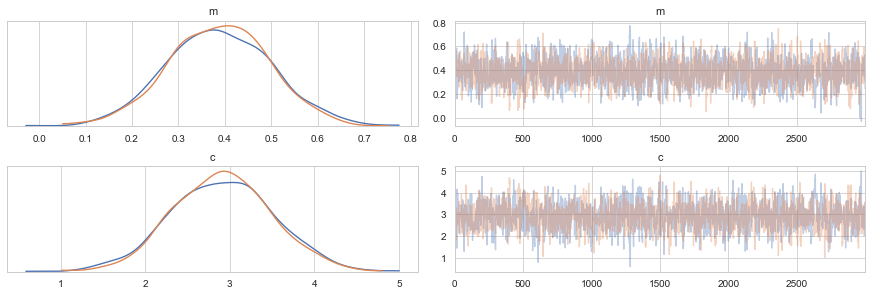

In [45]:
# plot the traces
_ = pm.traceplot(trace,) #lines={'m': mtrue, 'c': ctrue})

# put the chains in an array (for later!)
samples_pymc3_3 = np.vstack((trace['m'], trace['c'])).T



Auto-correlation length (Theanp Op (no grad)): 6
Auto-correlation length (Theano Op (with grad)): 3
Auto-correlation length (Pure PyMC3): 4


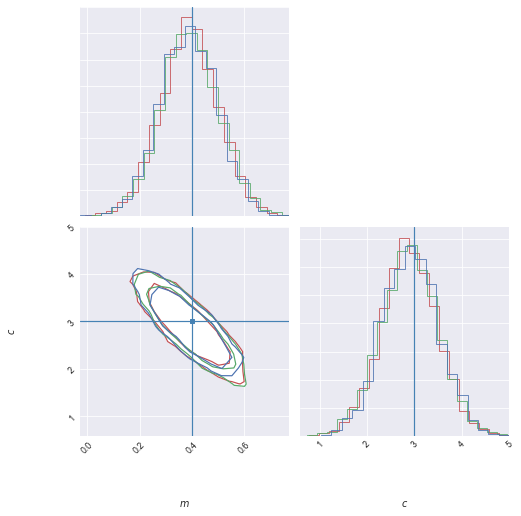

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # supress emcee autocorr FutureWarning

matplotlib.rcParams['font.size'] = 18

hist2dkwargs = {'plot_datapoints': False,
                'plot_density': False,
                'levels': 1.0 - np.exp(-0.5 * np.arange(1.5, 2.1, 0.5) ** 2)} # roughly 1 and 2 sigma

colors = ['r', 'g', 'b']
labels = ['Theanp Op (no grad)', 'Theano Op (with grad)', 'Pure PyMC3']

for i, samples in enumerate([samples_pymc3, samples_pymc3_2, samples_pymc3_3]):
    # get maximum chain autocorrelartion length
    autocorrlen = int(np.max(emcee.autocorr.integrated_time(samples, c=3)));
    print('Auto-correlation length ({}): {}'.format(labels[i], autocorrlen))

    if i == 0:
        fig = corner.corner(samples, labels=[r"$m$", r"$c$"], color=colors[i],
                            hist_kwargs={'density': True}, **hist2dkwargs,
                            truths=[mtrue, ctrue])
    else:
        corner.corner(samples, color=colors[i], hist_kwargs={'density': True},
                      fig=fig, **hist2dkwargs)

fig.set_size_inches(8, 8)

In [52]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))
grad_vals = test_grad_op_func([mtrue, ctrue])

print('Gradient returned by "LogLikeGrad": {}'.format(grad_vals))

# test the gradient called through LogLikeWithGrad
test_gradded_op = LogLikeWithGrad(my_loglike, data, x, sigma)
test_gradded_op_grad = tt.grad(test_gradded_op(var), var)
test_gradded_op_grad_func = theano.function([var], test_gradded_op_grad)
grad_vals_2 = test_gradded_op_grad_func([mtrue, ctrue])

print('Gradient returned by "LogLikeWithGrad": {}'.format(grad_vals_2))

# test the gradient that PyMC3 uses for the Normal log likelihood
test_model = pm.Model()
with test_model:
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    pm.Normal('likelihood', mu=(m*x + c), sigma=sigma, observed=data)

    gradfunc = test_model.logp_dlogp_function([m, c], dtype=None)
    gradfunc.set_extra_values({'m_interval__': mtrue, 'c_interval__': ctrue})
    grad_vals_pymc3 = gradfunc(np.array([mtrue, ctrue]))[1]  # get dlogp values

print('Gradient returned by PyMC3 "Normal" distribution: {}'.format(grad_vals_pymc3))

Gradient returned by "LogLikeGrad": [-7.17656625 -1.39486358]
Gradient returned by "LogLikeWithGrad": [-7.17656625 -1.39486358]


INFO (theano.gof.compilelock): Refreshing lock /Users/Toshiaki/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.2-64/lock_dir/lock


Gradient returned by PyMC3 "Normal" distribution: [-7.17656625 -1.39486358]


In [53]:
# profile logpt using our Op
opmodel.profile(opmodel.logpt).summary()

Function profiling
  Message: /Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pymc3/model.py:1023
  Time in 1000 calls to Function.__call__: 4.769230e-02s
  Time in Function.fn.__call__: 2.964449e-02s (62.158%)
  Time in thunks: 2.601361e-02s (54.545%)
  Total compile time: 2.538252e-01s
    Number of Apply nodes: 8
    Theano Optimizer time: 1.784480e-01s
       Theano validate time: 8.513927e-04s
    Theano Linker time (includes C, CUDA code generation/compiling): 5.992889e-03s
       Import time 0.000000e+00s
       Node make_thunk time 5.422115e-03s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}[(0, 1)](TensorConstant{2.995732273553991}, c, TensorConstant{-10.0}, TensorConstant{10.0}, TensorConstant{-2.995732273553991}, TensorConstant{-inf}, TensorConstant{2.0}, c_interval__) time 1.170874e-03s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2

In [54]:
# profile using our PyMC3 distribution
pymodel.profile(pymodel.logpt).summary()

Function profiling
  Message: /Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pymc3/model.py:1023
  Time in 1000 calls to Function.__call__: 3.282189e-02s
  Time in Function.fn.__call__: 1.027203e-02s (31.296%)
  Time in thunks: 4.787445e-03s (14.586%)
  Total compile time: 2.387913e+00s
    Number of Apply nodes: 11
    Theano Optimizer time: 1.853299e-01s
       Theano validate time: 1.447439e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.171522e+00s
       Import time 1.635385e-02s
       Node make_thunk time 2.169681e+00s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE((i1 + i2), i1) * LE((i1 + i2), i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}[(0, 2)](TensorConstant{2.995732273553991}, TensorConstant{-10.0}, Elemwise{Composite{(i0 * scalar_sigmoid(i1))}}.0, TensorConstant{10.0}, TensorConstant{-2.995732273553991}, TensorConstant{-inf}, TensorConstant{2.0}, c_interval__) time 1.118125e+00s
        